In [1]:
%matplotlib inline

### os
import os
import sys

### datetimes
from datetime import datetime, timedelta

### scipy
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import cartopy.crs as ccrs
import dask
from dask.diagnostics import ProgressBar
from tqdm import tqdm

### plotting
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns


In [2]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd()

In [3]:
sys.path.append('../../') 

In [4]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

In [5]:
dpath = CWD.parents[1].joinpath("outputs/ICU_validation/admin")

In [6]:
lfiles = list(dpath.glob("validation_*_seasonal_MME_tercile.csv"))

In [7]:
len(lfiles)

73

### sort the files per creation date, should start with Northern Mariana Island and end with Northern Marshall Islands 

In [8]:
lfiles.sort(key=os.path.getctime)

In [9]:
lfiles[0]

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/validation_Northern_Mariana_Islands_Southern_Islands_seasonal_MME_tercile.csv')

In [10]:
lfiles[-1]

PosixPath('/home/nicolasf/operational/ICU/development/hotspots/code/ICU_Water_Watch/outputs/ICU_validation/admin/validation_Marshall_Islands_Northern_Marshall_Islands_seasonal_MME_tercile.csv')

In [11]:
lfnames = [x.name for x in lfiles]

In [12]:
lfnames = sorted(lfnames)

In [13]:
lfnames

['validation_American_Samoa_Manua_seasonal_MME_tercile.csv',
 'validation_American_Samoa_Swains_seasonal_MME_tercile.csv',
 'validation_American_Samoa_Tutuila_seasonal_MME_tercile.csv',
 'validation_Cook_Islands_Northern_Cook_Islands_seasonal_MME_tercile.csv',
 'validation_Cook_Islands_Southern_Cook_Islands_seasonal_MME_tercile.csv',
 'validation_FSM_Chuuk_seasonal_MME_tercile.csv',
 'validation_FSM_Kapingamarangi_seasonal_MME_tercile.csv',
 'validation_FSM_Kosrae_seasonal_MME_tercile.csv',
 'validation_FSM_Pohnpei_seasonal_MME_tercile.csv',
 'validation_FSM_Yap_seasonal_MME_tercile.csv',
 'validation_Fiji_Central_seasonal_MME_tercile.csv',
 'validation_Fiji_Eastern_seasonal_MME_tercile.csv',
 'validation_Fiji_Northern_seasonal_MME_tercile.csv',
 'validation_Fiji_Rotuma_seasonal_MME_tercile.csv',
 'validation_Fiji_Western_seasonal_MME_tercile.csv',
 'validation_French_Polynesia_Austral_Islands_seasonal_MME_tercile.csv',
 'validation_French_Polynesia_Gambier_Islands_seasonal_MME_tercile

In [14]:
df_l = []
for fname in lfiles: 
    data = pd.read_csv(fname, index_col=0)
    df_l.append(data)

In [15]:
df = pd.concat(df_l, axis=1)

In [16]:
df = df.T

In [17]:
df = df.sort_values(by=3, ascending=False)

In [18]:
df.mean()

3    0.522532
4    0.503670
5    0.491782
dtype: float64

In [19]:
df.index = df.index.str.replace("Paua", "Papua")

In [20]:
df.head(5)

,3,4,5
Kiribati_Gilberts-North,0.784452,0.734043,0.722420
Kiribati_Gilberts-South,0.770318,0.723404,0.672598
Kiribati_Ocean_Island,0.752650,0.702128,0.665480
Kiribati_Northern_Line_Islands,0.727915,0.702128,0.693950
Nauru_Nauru,0.713781,0.684397,0.665480


In [21]:
df.tail(5)

,3,4,5
French_Polynesia_Austral_Islands,0.413428,0.336879,0.362989
French_Polynesia_Windward-Society_Islands,0.409894,0.354610,0.334520
Cook_Islands_Southern_Cook_Islands,0.378092,0.443262,0.355872
French_Polynesia_Gambier_Islands,0.360902,0.340909,0.343511
French_Polynesia_Leeward-Society_Islands,0.349823,0.347518,0.320285


In [39]:
df.to_csv("/home/nicolasf/Desktop/ACC_ICU_admin_boundaries_empirical_terciles.csv")

### reads the geopandas dataframe with the admin boundaries 

In [23]:
dpath = pathlib.Path(HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles/Admin_boundaries')) 

In [24]:
gdf = gpd.read_file(dpath.joinpath("ICU_Sub_bound.shp"))

### fix the issue with "Paua New Guinea Islands region"

In [25]:
gdf.loc[:,'Country'] = gdf.Country.str.replace("Paua", "Papua")

In [26]:
gdf.loc[:,'Country'] = gdf.loc[:,'Country'].apply(utils.sanitize_name)

In [27]:
gdf.loc[:,'Admin_boun'] = gdf.loc[:,'Admin_boun'].apply(utils.sanitize_name)

In [28]:
gdf.index = gdf.loc[:,'Country'] + '_' + gdf.loc[:,'Admin_boun']

<AxesSubplot:>

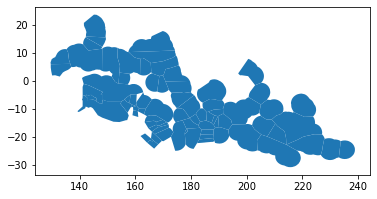

In [29]:
gdf.plot()

### all indices are now present 

In [30]:
set(list(df.index)) - set(list(gdf.index))

set()

In [31]:
gdf_validation = df.merge(gdf, left_index=True, right_index=True)

In [32]:
type(gdf_validation)

pandas.core.frame.DataFrame

In [33]:
gdf_validation = gpd.GeoDataFrame(gdf_validation)

In [34]:
type(gdf_validation)

geopandas.geodataframe.GeoDataFrame

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [36]:
cbar_kwargs = dict(shrink=0.5, boundaries=np.arange(0.3, 0.9, 0.1), drawedges=True)

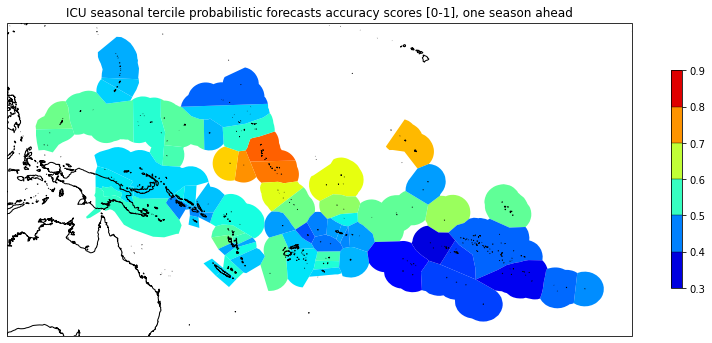

In [37]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14, 8))

gdf_validation.plot(ax=ax, column=3, transform=ccrs.PlateCarree(), legend=True, cmap=plt.cm.jet, vmin=0.3, vmax=0.9, legend_kwds=cbar_kwargs)

ax.coastlines(resolution='10m')

ax.set_title("ICU seasonal tercile probabilistic forecasts accuracy scores [0-1], one season ahead")

f.savefig('/home/nicolasf/Desktop/ICU_admin_ACC_map.png', dpi=200, bbox_inches='tight', facecolor='w')

In [41]:
gdf_validation

,3,4,5,id,Country,Admin_boun,geometry
Kiribati_Gilberts-North,0.784452,0.734043,0.722420,12,Kiribati,Gilberts-North,"POLYGON ((179.532 -0.013, 170.799 -0.190, 169...."
Kiribati_Gilberts-South,0.770318,0.723404,0.672598,13,Kiribati,Gilberts-South,"POLYGON ((170.799 -0.190, 179.532 -0.013, 179...."
Kiribati_Ocean_Island,0.752650,0.702128,0.665480,11,Kiribati,Ocean_Island,"POLYGON ((168.588 1.767, 169.929 1.973, 171.99..."
Kiribati_Northern_Line_Islands,0.727915,0.702128,0.693950,15,Kiribati,Northern_Line_Islands,"POLYGON ((200.541 7.910, 201.221 7.642, 201.41..."
Nauru_Nauru,0.713781,0.684397,0.665480,10,Nauru,Nauru,"POLYGON ((168.588 1.767, 167.823 -3.768, 167.5..."
...,...,...,...,...,...,...,...
French_Polynesia_Austral_Islands,0.413428,0.336879,0.362989,63,French_Polynesia,Austral_Islands,"POLYGON ((205.199 -19.249, 207.358 -19.948, 21..."
French_Polynesia_Windward-Society_Islands,0.409894,0.354610,0.334520,65,French_Polynesia,Windward-Society_Islands,"POLYGON ((210.266 -15.328, 211.049 -16.213, 21..."
Cook_Islands_Southern_Cook_Islands,0.378092,0.443262,0.355872,25,Cook_Islands,Southern_Cook_Islands,"POLYGON ((194.799 -15.646, 199.549 -15.514, 19..."
French_Polynesia_Gambier_Islands,0.360902,0.340909,0.343511,62,French_Polynesia,Gambier_Islands,"POLYGON ((214.217 -22.845, 218.405 -21.026, 22..."


In [50]:
gdf_validation.query("Country == 'Vanuatu'")

,3,4,5,id,Country,Admin_boun,geometry
Vanuatu_Sanma,0.586572,0.563830,0.583630,40,Vanuatu,Sanma,"POLYGON ((164.65000 -17.00000, 163.30561 -14.7..."
Vanuatu_Torba,0.565371,0.542553,0.519573,41,Vanuatu,Torba,"POLYGON ((163.30561 -14.76944, 163.55572 -13.6..."
Vanuatu_Penama,0.551237,0.524823,0.540925,39,Vanuatu,Penama,"POLYGON ((167.39846 -15.76310, 167.42271 -14.6..."
Vanuatu_Shefa,0.522968,0.563830,0.519573,37,Vanuatu,Shefa,"POLYGON ((165.91965 -18.18292, 168.14108 -16.5..."
Vanuatu_Tafea,0.491166,0.524823,0.505338,36,Vanuatu,Tafea,"POLYGON ((166.92257 -19.10641, 172.00000 -16.8..."
Vanuatu_Malampa,0.473684,0.462121,0.488550,38,Vanuatu,Malampa,"POLYGON ((164.65000 -17.00000, 167.23023 -15.8..."


In [48]:
len(gdf_validation.Country.unique())

22

In [49]:
gdf_validation.Country.unique()

array(['Kiribati', 'Nauru', 'Tuvalu', 'Tokelau', 'Palau', 'Vanuatu',
       'Cook_Islands', 'French_Polynesia', 'Fiji', 'FSM', 'Tonga',
       'Papua_New_Guinea', 'Marshall_Islands', 'New_Caledonia',
       'Solomon_Islands', 'American_Samoa', 'Guam',
       'Northern_Mariana_Islands', 'Niue', 'Samoa', 'Pitcairn',
       'Wallis_et_Futuna'], dtype=object)